# The Patient Space - Spotting Alzheimer's Disease with optimal Transport

What do you think, how big is a file containing a modern brain scan of $1\,\text{cm}^3$ of tissue? Believe it or not - using advanced X-ray tomography, the breadth of a pixel can get down to $50 \text{nm}$. This means that the scan contains up to $8 \cdot 10^{15}$ voxels! That's around 3 billion 4K images! It's clear that analysing this kind of data needs an innovative approach. 



<img src='assets/Cells.jpg' style="display: block; max-width: 100%; height: auto; margin: auto; float: none!important;" width='431px' />[[1]](#study)


Here we will describe how to abstract from this great amount of information and try to classify whether a patient might have Alzheimer's disease based solely on their scan data, using screenings that have already been done by medical experts. This is what an exciting study called *Three-dimensional virtual histology of the human hippocampus based on phase-contrast computed tomography* did in 2021. It was conducted by researchers from the University of Göttingen's [Collaborative Research Center 1456](https://www.uni-goettingen.de/en/630748.html). You can read the original, published in the *Proceedings of the National Academy of Sciences of the United States of America*, [here](https://www.pnas.org/doi/full/10.1073/pnas.2113835118).

The basic outline is

1. Take 3D hippocampus scans from patients with and without Alzheimer's disease
2. Train a neural network to mark and segment cell nuclei in the tissue
3. Record different mechanistically distiguishable features for each nucleus:
    - Median electron density $\rho$
    - Normalized lectron density variance $s = (\sigma/\rho)^2$
    - Nucleus volume $V$
    - Sphericity $\varphi$, basically how round they are
    - The number of neighboring nuklei close by, $nn$
4. (Optional) Approximate the patients' cell data by a multidimensional Gaussian distribution
5. Embed each patient's cell point cloud as a single point in a high-dimensional vector space
6. Apply [pricipal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to extract the most important information into a short vector
7. Classify the patients by their attribute vector using a simple [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine)

The optimal transport's job is step 4 and 5. To get a broad sense for scale, the scans used here are $1 \text{mm}^3$ in volume. Step 2 yields a number of usable nuclei between 600 and 6000 depending on the scan, with 5 features each. The main task of optimal transport is to quantify how closely the patients' data points resemble each other.

In [the last installment](Pointwise_Correlation.ipynb) in this series of notebooks, we already covered some useful basics of optimal transport. If you haven't read it that's fine, but you might need to look up some terms. And as a last note before exploring this ourselves, there is a stunning [video](https://ot.cs.uni-goettingen.de/video_histology2022.html) explaining the steps above, by Bernhard Schmitzer and Clément Sarrazin. Both are researchers in the field and the latter is one of the authors of the paper, so be sure to have look!

## Seeing in point clouded Skies

The similarity of two patients conditions here is the similarity between their cell feature point clouds. To rigorously study this similarity, we take a clue from natural language. *Closely* resemble, as said earlier, means that in some sense, the point clouds are spatially close together. In mathematics, a metric is what is needed to descibe this.

We can understand two point clouds as measures $\mu, \nu$, in this case on a subspace of $\mathbb R^5$, because we have 5 characteristics for each point. Optimal transport distances between measures $\mu, \nu$ are computed by taking an admissable transport plan $\gamma$ such that its first marginal is $\mu$ and its second marginal $\nu$ and then computing:

$$\int c(x, y) \text d \gamma(x,y)$$

Where $c(x,y)$ is the cost of transporting a point from $x$ to $y$. This should intuitively be something like the distance of the two points. We know how to define metrics on the base space $\mathbb R^5$. So we take such a metric $d$, maybe the euclidian distance, and simply say $c(x,y) := d(x,y)$.

Optimal transport now gives us a metric on the space of measures by taking the infimum over the optimal transport cost of admissable transport plans from $\mu$ to $\nu$. In fact it can be shown that there is an optimal transport plan $\gamma_o$ that has minimal possible distance. This leads us to a well defined notion of a metric between the two point clouds, the *Wasserstein* distance:

$$W_1(\mu, \nu) = \inf_\gamma \int d(x, y) \text d \gamma(x,y)$$

Taking a clue from the $L_p$-norm, we can also define the $p$-th Wasserstein distance:

$$W_p(\mu, \nu) = \left({\inf_\gamma \int d(x, y)^p \text d \gamma(x,y)}\right)^\frac{1}{p}$$

Below is an excerpt from Fig. 7 in the paper, where the Wasserstein distance of one feature, the electron density $\rho$, was computed between every pair of patients. Already, we could try to draw conclusions about the data. Is there anything you notice in particular?

<img style="display: block; max-width: 50%; height: auto; margin: auto; float: none!important;" src="assets/wasserstein.jpg">[[1]](#study)

## The Data

Let's load the results from the nucleus segmentation after step 3:

In [6]:
from lib.header_notebook import *
from lib.misc import *
import lib.SinkhornNP as Sinkhorn
import lib.LinHK as LinHK
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Checkbox, widgets

# some housekeeping to be consistent with the original file structure
filenameRoot="data/"
tagId="2020-12-08_full/prep_2020-12-28_IQR-filter"

# load point cloud for reference measure
ptsRef = importPts(filenameRoot+tagId+"/pts_ref.mat")
nPtsRef = ptsRef.shape[0]
muRef = np.full(nPtsRef,1./nPtsRef)

# load analysis parameters
with open(filenameRoot+tagId+"/params_HK.json","r") as f:
    params = json.load(f)
    f.close()
    
# load all point clouds
ptsFullSamples = []
for n in range(17):
    ptsSample = importPts(filenameRoot+tagId+"/pts_"+str(n).zfill(3)+".mat")
    ptsFullSamples.append(ptsSample)
    print("Loaded {:04d} nuclei with {} features for patient No. {:02d}!".format(ptsSample.shape[0], ptsSample.shape[1], n + 1))
    

Loaded 2389 nuclei with 5 features for patient No. 01!
Loaded 1608 nuclei with 5 features for patient No. 02!
Loaded 3864 nuclei with 5 features for patient No. 03!
Loaded 6090 nuclei with 5 features for patient No. 04!
Loaded 5907 nuclei with 5 features for patient No. 05!
Loaded 2323 nuclei with 5 features for patient No. 06!
Loaded 1882 nuclei with 5 features for patient No. 07!
Loaded 3901 nuclei with 5 features for patient No. 08!
Loaded 0680 nuclei with 5 features for patient No. 09!
Loaded 3167 nuclei with 5 features for patient No. 10!
Loaded 1183 nuclei with 5 features for patient No. 11!
Loaded 3456 nuclei with 5 features for patient No. 12!
Loaded 4240 nuclei with 5 features for patient No. 13!
Loaded 2570 nuclei with 5 features for patient No. 14!
Loaded 5709 nuclei with 5 features for patient No. 15!
Loaded 5210 nuclei with 5 features for patient No. 16!
Loaded 2820 nuclei with 5 features for patient No. 17!


## Linear Embeddings and the Barycenter

This brings us to step 5, where we need to embed the point cloud into a vector space which subsequent algorithms can work with. The trouble is that, as you can see above, we have to encode point clouds that don't even have the same amount of points with one map. Optimal transport solves this problem, because it can compare everything that can be described as a measure. Here, we simply give every point a weight inversely proportional to the number of points in its point cloud. In the end, we will obtain a vector in the tangent space, comprising of the vector fields 'shooting' point clouds onto each other. These vector fields are defined on all of $\mathbb R^5$, they just happen to be $0$ when there is no point to shoot. Therefore, they can all be treated as the same kind of objects mathematically.

But first, we need something to shoot onto the point clouds in the first place. For this purpose we find a sort of average measure $\tilde \mu$ with, we somewhat arbitrarily choose, 10000 points. This is the center of mass - the barycenter - which is defined by taking the least amount of effort to transport onto all the other measures $\mu_i$. This is what optimal transport is made for; minimizing a cost function for mapping one measure onto another. Our cost function here is the Wasserstein distance (or the Hellinger-Kantorovich distance, explained below).
The barycenter $\tilde \mu$ is also called reference measure. This is because the map which gets us into the tangent space, the so called logarithmic map $\log_{\tilde \mu}$, will take any measure (point cloud) $\mu_i$ to the vector field that points from $\tilde \mu$ to it. The vector field is $0$ everywhere, except for the points which belong to points assigned a non-zero weight by $\tilde \mu$, at which there is a vector pointing to non-zero weights of $\mu_i$. 
(Similarly, we call the inverse of the logarithmic - this sends such a vector field back to $\mu_i$ - the exponential map.)

These vector fields are now all on the same domain and can be compared and analyzed further. Also, since they describe a sort of difference from the mean $\mu_i$, they are centered around the $0$ in this vector space.


**Extra: The Hellinger-Kantorovich distance**
The distance to the other measures that the barycenter minimizes could be the Wasserstein distance as discussed above. However, in practice this can be suboptimal, especially as the point cloud measures $\mu_i$ have a greatly varying amount of points. What can be used instead is the Hellinger-Kantorovich distance, which also introduces a term corresponding to adding virtual mass to the input point cloud to be transported, although doing this is penalized by a coefficient $\kappa$. Through this, the mass that is transported can be switched around between points also, which may be thought of as allowing the algorithm to choose to some degree which points are 'more important'. For $\kappa$ very large, morphing mass is so expensive that the Hellinger-Kontorovich distance is equal to the Wasserstein distance. For $\kappa$ small, the algorithm simply teleports points around, ignoring the data entirely, so the choice of this parameter is important.

The field of Optimal Transport harbors many of these notions of distance, which can all be of use with different data sets. 

### Visualizing Embeddings

The code below imports the linear embeddings for each patient and lets us visualize them as point clouds. You can select two features and see the point cloud distributions in those two dimensions for all the patients. The red point clouds are from afflicted patients and the blue ones from the control group.

The heavy lifting of optimal transport was done by code written by one of the paper's authors, Bernhard Schmitzer. It is open source and you can find it [here](https://github.com/bernhard-schmitzer/UnbalancedLOT).

In [7]:
# These are the parameters given to the optimal transport algotihm
nSamples=params["nSamples"]
HKScale=params["setup_HKScale"]
scales=HKScale
nScales=len(HKScale)
iScaleList=np.arange(nScales)

# Importing metadata like the classification of patients
classes=np.array(sciio.loadmat(filenameRoot+tagId+"/classes.mat")["classes"],order="C",dtype=int).ravel()
classlabel=["Patient with Alzheimer","Control"]

featureNames=["Median Electron Density","Electron Density Variance","Nucleus Volume","Sphericity","Number of Neighbors"]
nFeatures=len(featureNames)

sampleTags=sciio.loadmat(filenameRoot+tagId+"/sampleTags.mat")["sampleTags"]

# Extracting and formatting the patient data
import pickle
linEmbList=[]
for scale in HKScale:
    with open(filenameRoot+tagId+"/linEmbHK_s={}.dat".format(scale), 'rb') as f:
        fullEmb=pickle.load(f)
        sampleNr = 1
        linEmb=[(a[0],a[1]) for a in fullEmb]
        minMass = 1
        minNr = 1
        for a in fullEmb:
            if np.round(np.sum(LinHK.HKExp(muRef,ptsRef,a[0],a[1],scale)[0]),3) <= minMass:
                minMass=np.round(np.sum(LinHK.HKExp(muRef,ptsRef,a[0],a[1],scale)[0]),3)
                minNr=sampleNr
            sampleNr+=1
        f.close()
    
    linEmbEucl,linEmbMean=LinHK.buildDataMatrix(linEmb, muRef, scale)
    linEmbList.append((linEmbEucl,linEmbMean))
    tanLinEmbMean = LinHK.decomposeEigenvectors(linEmbMean.reshape((1,-1)),muRef,scale)[0]

class_colors = ["crimson","navy"]
class_labels=["Alzheimer","Control"]

def plot_data(i_feat,j_feat, draw=False, n=3):
    pltsize = 6
    iScale = iScaleList[0]
    scale = scales[iScale]

    linEmbList_scale = linEmbList[iScale]

    fig, ax = plt.subplots(n,int(np.ceil(17/n)), sharex = True, sharey = True, figsize = (pltsize*np.ceil(17/n),pltsize*n))

    for i,linEmb in enumerate(linEmbList_scale[0]):
        # Samples
        ptsTrue = ptsFullSamples[i]
        muTrue = np.ones(len(ptsTrue))/len(ptsTrue)
        
        ax[i%n,int(i/n)].scatter(ptsTrue.T[featureNames.index(i_feat)],ptsTrue.T[featureNames.index(j_feat)], color = class_colors[classes[i]],s=1,alpha = 0.4)
        ax[i%n,int(i/n)].set_title("No. "+str(i+1)+" - "+ class_labels[classes[i]])
        ax[i%n,int(i/n)].set_xlabel(i_feat)
        ax[i%n,int(i/n)].set_ylabel(j_feat)

#Creating widgets for interactive Visualization
n_widget = widgets.IntSlider(
    min=2,max=5, value=3,
    continuous_update = False,
    description='Rows:'
)

i_widget = widgets.Select(
    options=featureNames,
    value='Median Electron Density',
    description='X-Axis:'
)

j_widget = widgets.Select(
    options=featureNames,
    value='Electron Density Variance',
    description='Y-Axis:'
)

ui = widgets.HBox([i_widget,j_widget, n_widget])
widget = interactive(plot_data, i_feat=0,j_feat=1, n=3)
out = widgets.interactive_output(plot_data, {'i_feat': i_widget,'j_feat': j_widget,'n':n_widget})

display(ui, out)

Output()

## Classification - Leveraging results from Optimal Transport

You might find that the above data is still hard to interpret by hand.

Thankfully, due to the linear embedding, we may now use principal component analysis, a more standard technique in data science. The linear embeddings are still in a many-thousand dimensional vector space, but they can be described using only very few coordinates that carry the significant information underlying the data. Run the code below to see how little basis vectors are needed to explain how much of the variance. $\sigma_n$ is a lower bound for the explained variance.

In [8]:
def PCA_interactive(variance):
    PCAList=[]
    keepList=[]
    eigvalFullList=[]

    for lin in linEmbList:
        # This computes the PCA
        eigvalFull,eigvec=PCA(lin[0],keep=None)
        
        keep=0
        sumEigval=0
        fraction=0

        eigvalTot=np.sum(eigvalFull)
        while fraction<variance:
            fraction+=eigvalFull[keep]/eigvalTot
            keep+=1    
        print("fraction of captured variance:")
        print(fraction)
        keepList.append(keep)

    print("")
    print("Number of PCA vectors kept:",keepList)

variance_widget = FloatSlider(description='$\sigma$', 
                     min=0.01, max=0.99, value=0.8, step=0.01)
    
ui = widgets.VBox([variance_widget])
widget = interactive(PCA_interactive, variance=0.7)
out = widgets.interactive_output(PCA_interactive, {'variance': variance_widget})

display(ui, out)

Output()

### A look into the Patient Space

Now that we have found a basis that summarizes the data, we can have a meaningful look at the patient space! Below is a plot of the first two coordinates in the computed PCA basis.

In [9]:
PCAList=[]
coordList=[]

PCA_results = PCA(linEmbList[0][0],keep=None)
eigval=PCA_results[0][:4]
eigvec=PCA_results[1][:4]
PCAList.append((eigvec,eigval))

coordList=[]
for lin,ev in zip(linEmbList,PCAList):
    coordList.append(np.einsum(ev[0],[0,1],lin[0],[2,1],[2,0]))
coords = coordList[0]

axsel=[0,1,2]
fig=plt.figure(facecolor="w")
for i in range(2):
    sel=(classes==i)
    plt.scatter(coords[sel,axsel[0]],coords[sel,axsel[1]],c=colors[i],label=classlabel[i])
for j in range(nSamples):
    plt.annotate(j,xy=(coords[j,axsel[0]]+0.02,coords[j,axsel[1]]+0.02))
plt.legend()
plt.xlabel("PCA Direction 1")
plt.ylabel("PCA Direction 2")
plt.title("Coordinates in PCA eigenbasis of all samples")
plt.tight_layout()
plt.show()

We might also do the same in three coordinates. The picture above is a projection on the ground plane in the one below. It's visible, in both pictures, that the variation in the primary PCA basis vector is indeed larger than the secondary one, and the third explains even less variation. In both, we can see somewhat of a clustering into healthy and afflicted subjects.

In [10]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
for m,i in [('o',0),('^',1)]:
    sel=(classes==i)
    ax.scatter(coords[sel,axsel[0]],coords[sel,axsel[1]],coords[sel,axsel[2]],marker=m,label=classlabel[i])
ax.legend()
ax.set_xlabel("PCA Direction 1")
ax.set_ylabel("PCA Direction 2")
ax.set_zlabel("PCA Direction 3")

Text(0.5, 0, 'PCA Direction 3')

Lastly, we want to classify the patients with this condensed information and learn something about what it means to have Alzheimer's disease. This is the last step, for which the State Vector Machine, another classic tool of data science will help us. Our goal is to find a hyperplane that cuts through the dimensionality-reduced patient space and seperates the control group from the afflicted patients. This can also work quite well when the data is not perfectly seperable by such a hyperplane which is the case here. 

Below, we color the dots based on this classification and compare with a classification score decribing the severity of Alzheimer's disease assessed by medical experts.

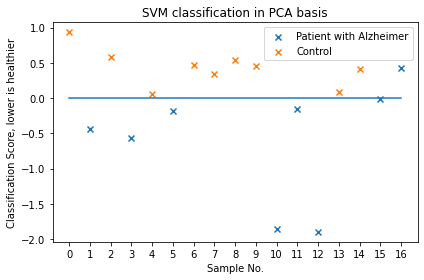

In [13]:
# We apply a very basic linear SVM (support vector machine) to samples in PCA space

from sklearn.svm import LinearSVC

keptSamples=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15]

vecSVMList=[]
for iScale in range(nScales):
    coords=coordList[iScale]
    clf=LinearSVC(loss="squared_hinge")
    clf.fit(coords[keptSamples],classes[keptSamples]);
    vecSVM=clf.coef_[0]
    vecSVMNorm=np.linalg.norm(vecSVM)
    vecSVM=vecSVM/vecSVMNorm
    vecSVMList.append((vecSVM, clf.intercept_/vecSVMNorm))

fig=plt.figure(facecolor="w", figsize=(6,4*nScales))
for iScale,s in enumerate(HKScale):
    fig.add_subplot(nScales,1,iScale+1)
    vecSVM,interceptSVM=vecSVMList[iScale]
    #print(interceptSVM)
    vecSVMNorm=np.linalg.norm(vecSVM)
    coords=coordList[iScale]
    coordsSVM=np.einsum(vecSVM,[1],coords,[0,1],[0])+interceptSVM
    xcoords=np.arange(nSamples)
    plt.title("HKscale={}".format(s))
    for i in range(2):
        sel=(classes==i)
        plt.scatter(xcoords[sel],coordsSVM[sel],marker="x",label=classlabel[i],c=colors[i])
    plt.plot(np.zeros_like(coordsSVM))
    plt.legend()
    plt.title("SVM classification in PCA basis")
    plt.xticks(np.arange(nSamples,dtype=int))
    plt.xlabel("Sample No.")
    plt.ylabel("Classification Score, lower is healthier")
plt.tight_layout()
plt.show()

And we see that, indeed, there is somewhat of a seperation into healthy and unhealthy people just based on the optimal transport analysis in the low dimensional vector space approximating the patient space.

With this done, we can look at the normal of the hyperplane, the vector which points perpendicular to the plane seperating afflicted patients from the control group. This vector gives an abstract idea of 'what it means to be' sick. That is, adding it to any patient, we could guess that it would take the point into a more pathological state, because it points into the direction of all the other afflicted patients and away from the healthy ones. This is merely a conjecture - such a linearity taking effect in the real world is not guaranteed at all - but this might help to give pointers to what may be involved in the disease.

It is also be possible to work the steps backwards and produce point cloud distributions from the normal vector! This is done by applying the hyperplane normal (which is, remember, a vectorfield in the tangent space describing a mapping of the reference measure) to the reference measure. We can scale the hyperplane normal by a factor, positive or negative, to produce something like an especially "healthy" and "afflicted" point cloud distribution as induced by the labeled data. These fictional patients' point clouds are graphed below. Here, it becomes quite clear which cell features might be candidates for further medical research over the others, which is a great accomplishment if we remember what involved data we started with.

The histogram for '--' (purple) is for a - computed - typical patient much more afflicted then the mean in the sample, the one for '++' for a typical patient much healthier than the mean. '-' (dark blue) is moderately more afflicted than the barycenter, '0' (light blue) is the reference measure and '+' moderately healthier than the mean.

See for yourself: Which feature distribution are supposedly characteristic for Alzheimer's desease?
And more importantly: Are you convinced by a statistical method such as this one? Do you think it accurately reflects the data itself?

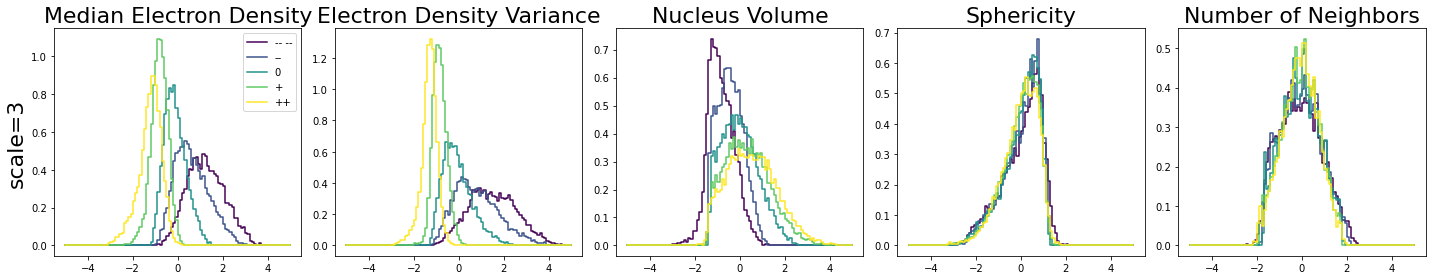

In [14]:
# Some formatting for 
vList=[
    np.array([1.,0.,0.,0.,0.]),  
    np.array([0.,1.,0.,0.,0.]),  
    np.array([0.,0.,1.,0.,0.]),  
    np.array([0.,0.,0.,1.,0.]),  
    np.array([0.,0.,0.,0.,1.])
    ]

xmin,xmax=[-5,5]
nBins=100
xspace=np.linspace(xmin,xmax,num=100)

numS=5
sList=np.linspace(-3,3,num=numS)
lList=["-- --","--","0","+","++"]

scales=[3]#HKScale
nScales=len(scales)
fig=plt.figure(facecolor="w",figsize=(4*nFeatures,4*nScales))
for iScale,s in enumerate(scales):
    vecSVM,_=vecSVMList[iScale]
    eigvec,_=PCAList[iScale]
    linEmbMean=linEmbList[iScale][1]
    linEmbMean = LinHK.decomposeEigenvectors(linEmbMean.reshape((1,-1)),muRef,scale)[0]
    tan=np.einsum(vecSVM,[0],eigvec,[0,1],[1])
    # mode as relative transport map
    tan=LinHK.decomposeEigenvectors(tan.reshape((1,-1)), muRef,s)[0]
    for iFeat,vect in enumerate(vList):
        fig.add_subplot(nScales,nFeatures,iScale*nFeatures+iFeat+1)
        for iTime, t in enumerate(sList):
            # reference measure push forward
            muRefPush,ptsRefPush=LinHK.HKExp(muRef,ptsRef,linEmbMean[0]+t*tan[0],linEmbMean[1]+t*tan[1],s)
            pts1d=np.einsum(vect,[0],ptsRefPush,[1,0],[1])
            frq,edges=np.histogram(pts1d,bins=nBins,range=[xmin,xmax])
            
            # renormalizing
            frq=frq/(nPtsRef*(xmax-xmin)/nBins)
            
            # histogram plot
            plt.step(edges,np.concatenate((np.array([0.]),frq)),c=cm.viridis(iTime/(numS-1)),label=lList[iTime])
        if iScale==0:
            plt.title(featureNames[iFeat],fontsize=22)
        if iFeat==0:
            plt.ylabel("scale={}".format(s),fontsize=22)
            plt.legend(loc=1)
plt.tight_layout()
plt.show()

This concludes our adventure through a very interesting medical data set with optimal transport. This showcase has of course barely scratched the surface of research being currently done on optimal transport in the University of Göttingen's [CRC 1456](https://www.uni-goettingen.de/en/628179.html). Perhaps more exitingly, the field of optimal transport itself is only at the very beginning of developing statistical tools ready to be used in the natural sciences and many delopments are to be expected from all over the world. If you want to contribute yourself or learn more, our university's research group might be just the place for you. Many different projects that bring together many academic disciplines, like this this one here, can be found on [its web page](https://www.uni-goettingen.de/en/projects/628437.html).

Thank you for reading!

****
<a id='study'></a>[1] From the study *Three-dimensional virtual histology of the human hippocampus based on phase-contrast computed tomography* published in *Proceedings of the National Academy of Sciences* Vol. 118 under the [CC BY-NC-ND 4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/) license - © 2021 the Authors, by whom permission of use was kindly given.

_Written by Fabian Fieberg and Lennart Finke. Published under the [MIT](https://mit-license.org/) license._